In [1]:
import random
import time
import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Sampler
import torchvision.datasets as datasets

In [2]:
data_directory = './'

In [3]:
torchvision.datasets.Flowers102(root=f'{data_directory}', download=True)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./
    split=train

In [4]:
class TaskSampler(Sampler):
    
    def __init__(self, dataset, n_way, k_shot, n_query, n_tasks):
        super().__init__(data_source=None)
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_tasks = n_tasks
        self.n_query = n_query
        
        self.items_per_label = {}
        
        for item, label in enumerate(dataset.get_labels()):
            if label in self.items_per_label.keys():
                self.items_per_label[label].append(item)
            else:
                self.items_per_label[label] = [item]
                
    def __len__(self):
        return self.n_tasks
    
    def __iter__(self):
        for task in range(self.n_tasks):
            yield torch.cat(
                [
                    torch.Tensor(random.sample(self.items_per_label[label], self.k_shot + self.n_query)).type(torch.int)
                    
                    for label in random.sample(self.items_per_label.keys(), self.n_way)
                ]
            ).tolist()
            
    def collate_fn(self, input_data):
        true_class_ids = list({x[1] for x in input_data})

        all_images = torch.cat([x[0].unsqueeze(0) for x in input_data])
        all_images = all_images.reshape(
            (self.n_way, self.k_shot + self.n_query, *all_images.shape[1:])
        )

        all_labels = torch.tensor(
            [true_class_ids.index(x[1]) for x in input_data]
        ).reshape((self.n_way, self.k_shot + self.n_query))

        support_images = all_images[:, : self.k_shot].reshape(
            (-1, *all_images.shape[2:])
        )
        query_images = all_images[:, self.k_shot :].reshape((-1, *all_images.shape[2:]))
        support_labels = all_labels[:, : self.k_shot].flatten()
        query_labels = all_labels[:, self.k_shot :].flatten()

        return support_images, support_labels, query_images, query_labels, true_class_ids

In [5]:
class MatchingNetwork(torch.nn.Module):
    
    def __init__(self, backbone=None, image_size=224, use_full_contextual_embedding=True) -> None:
        super().__init__()
        
        self.use_full_contextual_embedding = use_full_contextual_embedding
        
        self.backbone = backbone
        
        if self.backbone is None:
            self.backbone = self.get_backbone()
        
        self.feature_size = self.get_output_shape(self.backbone, image_size)[0]
        
        self.support_encoder = torch.nn.LSTM(
            input_size=self.feature_size,
            hidden_size=self.feature_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        
        self.query_encoder = torch.nn.LSTMCell(self.feature_size * 2, self.feature_size)
        
        self.contextualized_support_features = None
        self.one_hot_support_labels = None
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    def get_backbone(self):
        backbone = torchvision.models.resnet18(pretrained=True)
        backbone.fc = torch.nn.Flatten()
        return backbone
                
    def encode_support_set(self, support_images, support_labels):

        support_features = self.backbone(support_images)
        
        if self.use_full_contextual_embedding:
            hidden_state = self.support_encoder(support_features.unsqueeze(0))[0].squeeze(0)
            self.contextualized_support_features = support_features + hidden_state[:, : self.feature_size] + hidden_state[:, self.feature_size :]
            
        else:
            self.contextualized_support_features = support_features

        self.one_hot_support_labels = torch.nn.functional.one_hot(support_labels).float()

    def encode_query_features(self, query_set):
        
        query_features = self.backbone(query_set)

        if not self.use_full_contextual_embedding:
            return query_features
        
        hidden_state = query_features
        cell_state = torch.zeros_like(query_features)

        for _ in range(len(self.contextualized_support_features)):
            attention = self.softmax(
                hidden_state.mm(self.contextualized_support_features.T)
            )
            read_out = attention.mm(self.contextualized_support_features)
            lstm_input = torch.cat((query_features, read_out), 1)

            hidden_state, cell_state = self.query_encoder(
                lstm_input, (hidden_state, cell_state)
            )
            hidden_state = hidden_state + query_features

        return hidden_state
        
    def get_output_shape(self, model, image_size):
        x = torch.randn(1, 3, image_size, image_size)
        out = model(x)
        return out.shape[1:]
    
    def forward(self, support_images, support_labels, query_images):
        
        self.encode_support_set(support_images, support_labels)
        
        contextualized_query_features = self.encode_query_features(
            query_images
        )
        
        similarity_matrix = self.softmax(
            contextualized_query_features.mm(
                torch.nn.functional.normalize(self.contextualized_support_features).T
            )
        )
                
        log_probabilities = (
            similarity_matrix.mm(self.one_hot_support_labels) + 1e-6
        ).log()
        
        return log_probabilities

In [6]:
image_size = 224

n_way = 5
k_shot = 3
n_query = 5
n_tasks = 100
n_epochs = 10
n_train_tasks = 100
n_val_tasks = 100
n_test_tasks = 1000

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size)),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]
)

In [8]:
training_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='train', transform=transform)
validation_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='val', transform=transform)
test_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='test', transform=transform)

print(f'Length of training data: {len(training_set)}')
print(f'Length of validation data: {len(validation_set)}')
print(f'Length of test data: {len(test_set)}')

Length of training data: 1020
Length of validation data: 1020
Length of test data: 6149


In [9]:
training_set.get_labels = lambda: [
    instance for instance in training_set._labels
]

validation_set.get_labels = lambda: [
    instance for instance in validation_set._labels
]

test_set.get_labels = lambda: [
    instance for instance in test_set._labels
]

In [10]:
train_sampler = TaskSampler(training_set, n_way, k_shot, n_query, n_train_tasks)
validation_sampler = TaskSampler(validation_set, n_way, k_shot, n_query, n_val_tasks)
test_sampler = TaskSampler(test_set, n_way, k_shot, n_query, n_test_tasks)

In [11]:
train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_sampler=train_sampler,
    collate_fn=train_sampler.collate_fn,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_sampler=validation_sampler,
    collate_fn=validation_sampler.collate_fn,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_sampler=test_sampler,
    collate_fn=test_sampler.collate_fn,
)


In [12]:
def evaluate_model(model, criterion, data_loader):
    
    model.eval()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    start_time = time.time()
    
    for support_images, support_labels, query_images, query_labels, _ in tqdm.tqdm(data_loader):
        
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        scores = model(support_images, support_labels, query_images)

        loss = criterion(scores, query_labels)

        running_loss += loss.item()
        total += query_labels.shape[0]
        _, preds = torch.max(scores, 1)
        running_correct += torch.sum(preds == query_labels).item()

    end_time = time.time()
    
    print(f'Loss: {running_loss / len(data_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
    
    return running_loss / len(data_loader), running_correct / total

In [13]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=100):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    total_time = 0.0
    
    for epoch in range(num_epochs):
        
        model.train()
        
        running_loss = 0.0
        running_correct = 0
        total = 0
        
        start_time = time.time()
        for support_images, support_labels, query_images, query_labels, _ in tqdm.tqdm(train_loader):
            support_images = support_images.to(device)
            support_labels = support_labels.to(device)
            query_images = query_images.to(device)
            query_labels = query_labels.to(device)
            
            optimizer.zero_grad()
            
            scores = model(support_images, support_labels, query_images)
            
            loss = criterion(scores, query_labels)
            
            running_loss += loss.item()
            total += query_labels.shape[0]
            _, preds = torch.max(scores, 1)
            running_correct += torch.sum(preds == query_labels).item()
            
            loss.backward()
            optimizer.step()
         
        end_time = time.time()
        
        scheduler.step()
        
        print(f'Epoch: {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
        
        total_time += end_time - start_time
        
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(running_correct / total)
        
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)
        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
    print(f'Average Training Time: {total_time / num_epochs}')
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [14]:
model = MatchingNetwork(image_size=image_size, use_full_contextual_embedding=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [16]:
history = train(model, criterion, optimizer, lr_scheduler, train_loader, validation_loader, num_epochs=n_epochs)

100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Epoch: 1, Loss: 0.11290818880777806, Accuracy: 0.9748, Time: 44.2576s


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Loss: 0.13496599099598824, Accuracy: 0.9556, Time: 36.7275s


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


Epoch: 2, Loss: 0.03647185713984072, Accuracy: 0.992, Time: 38.2508s


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Loss: 0.13352843790315091, Accuracy: 0.9596, Time: 37.4017s


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Epoch: 3, Loss: 0.03190625041432213, Accuracy: 0.9928, Time: 39.5026s


100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Loss: 0.11534340394311585, Accuracy: 0.9632, Time: 37.0445s


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Epoch: 4, Loss: 0.016484082225942984, Accuracy: 0.9976, Time: 38.5503s


100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Loss: 0.11447222645394504, Accuracy: 0.9648, Time: 37.0636s


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Epoch: 5, Loss: 0.023060418986424337, Accuracy: 0.9972, Time: 38.5102s


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


Loss: 0.11290023221867158, Accuracy: 0.9648, Time: 37.5404s


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Epoch: 6, Loss: 0.019386920609977095, Accuracy: 0.9964, Time: 38.7779s


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


Loss: 0.12204133629100397, Accuracy: 0.96, Time: 37.7331s


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


Epoch: 7, Loss: 0.01859374812571332, Accuracy: 0.998, Time: 38.1558s


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


Loss: 0.0997636077995412, Accuracy: 0.9676, Time: 37.7187s


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Epoch: 8, Loss: 0.016733381596277467, Accuracy: 0.9988, Time: 38.5850s


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


Loss: 0.11273576834006235, Accuracy: 0.9612, Time: 37.2010s


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Epoch: 9, Loss: 0.015046775154769421, Accuracy: 0.9984, Time: 38.5029s


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


Loss: 0.10791400075890124, Accuracy: 0.9672, Time: 36.6373s


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Epoch: 10, Loss: 0.018202082391362638, Accuracy: 0.9968, Time: 38.4567s


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]

Loss: 0.11828188593499363, Accuracy: 0.9624, Time: 37.1234s
Average Training Time: 39.15497453212738


In [17]:
train_loss, train_acc, val_loss, val_acc = history

In [18]:
def plot_curve(train_history, val_history, title='Model Accuracy', ylabel='Accuracy', legend_loc='upper left'):
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc=legend_loc)
    
    plt.show()

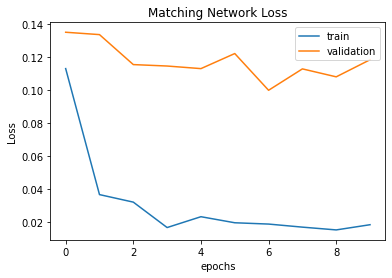

In [19]:
plot_curve(train_loss, val_loss, title='Matching Network Loss', ylabel='Loss', legend_loc='upper right')

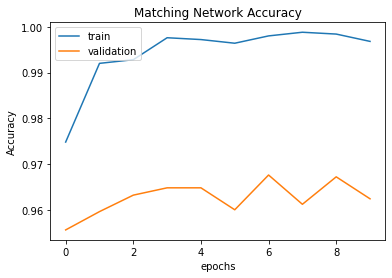

In [20]:
plot_curve(train_acc, val_acc, title='Matching Network Accuracy', ylabel='Accuracy', legend_loc='upper left')

In [21]:
print('Train: ', end='')
evaluate_model(model, criterion, train_loader)

print('Validation: ', end='')
evaluate_model(model, criterion, validation_loader)

print('Test: ', end='')
evaluate_model(model, criterion, test_loader);

Train: 

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Loss: 0.01979695511094178, Accuracy: 0.9956, Time: 38.4876s
Validation: 

100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Loss: 0.10418524964945391, Accuracy: 0.9704, Time: 37.4233s
Test: 

100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]

Loss: 0.11570412069855956, Accuracy: 0.9634, Time: 387.1413s


In [22]:
torch.save(model.state_dict(), "matching_network_episodic.pt")